In [2]:
import cv2
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from utils import *
import os

<IPython.core.display.Javascript object>


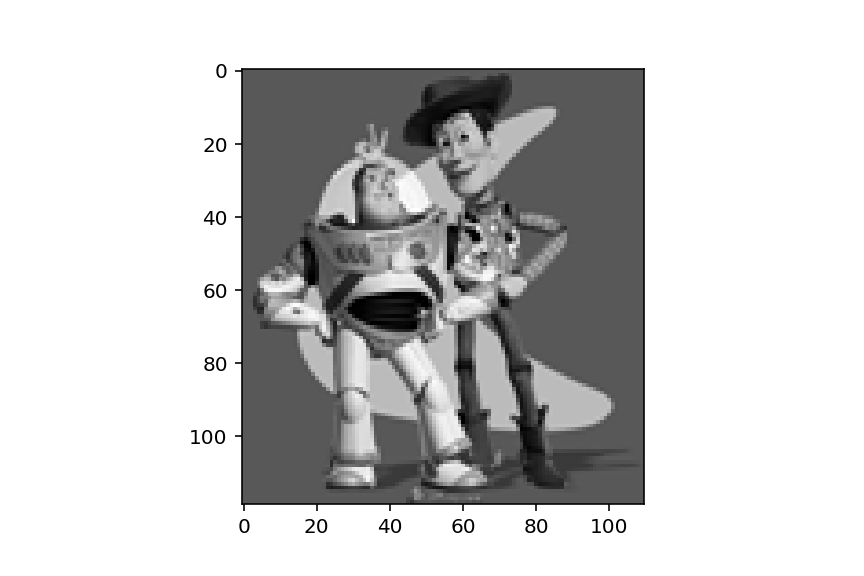

In [257]:
toy_img = cv2.imread('samples/toy_problem.png').astype(np.float64) / 255.0
plt.imshow(toy_img)

## Part 1 Toy Problem (20 pts)

In [258]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_h, im_w,_ = toy_img.shape 
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) 
    A = np.zeros((im_h*(im_w-1) + (im_h-1)*im_w + 1, im_h*im_w))
    b = np.zeros(im_h*(im_w-1) + (im_h-1)*im_w + 1)
    
    e = 0
    for y in range(im_h):
        for x in range(im_w-1):
            A[e][im2var[y][x+1]] = 1 
            A[e][im2var[y][x]] = -1 
            b[e] = toy_img[y][x+1][0] - toy_img[y][x][0]
            e += 1
    
    for y in range(im_h-1):
        for x in range(im_w):   
            A[e][im2var[y+1][x]] = 1 
            A[e][im2var[y][x]] = -1 
            b[e] = toy_img[y+1][x][0] - toy_img[y][x][0]
            e += 1
            
    A[e][im2var[0][0]] = 1 
    b[e] = toy_img[0][0][0]
    
    A = sp.sparse.csr_matrix(A)
        
    v = sp.sparse.linalg.lsqr(A, b, atol=10**-14, btol=10**-14)
    
    return v[0].reshape((im_h, im_w))

In [259]:
im_out = toy_reconstruct(toy_img)
print("Error is: ", np.sqrt(((im_out - toy_img[:,:,0])**2).sum()))

Error is:  2.0943120207502896e-10


## Preparation

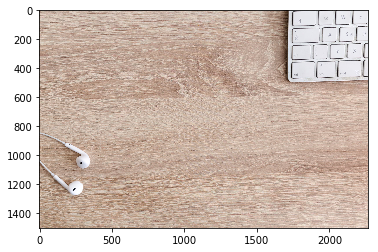

In [244]:
background_img = cv2.imread('samples/3.jpeg')
background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 # Feel free to change image
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


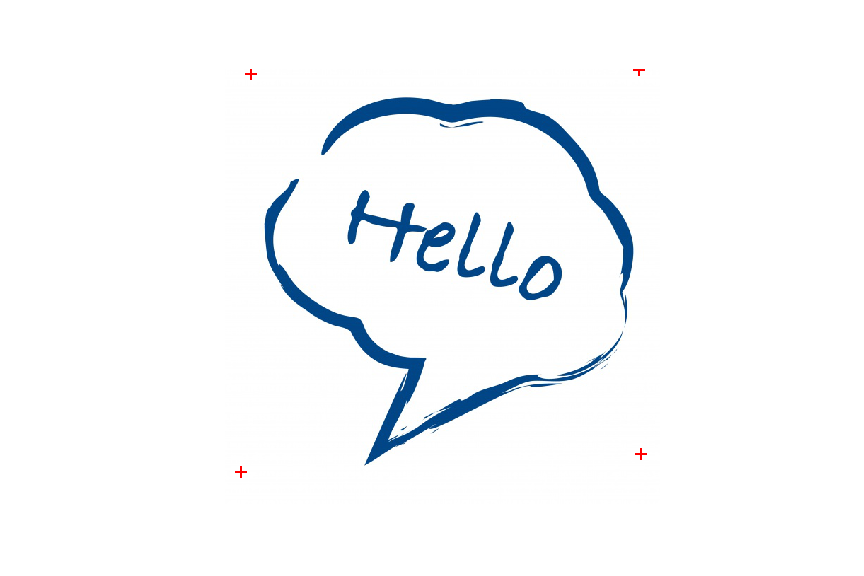

In [260]:
object_img = cv2.imread('samples/4.jpg')
object_img = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 # Feel free to change image
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

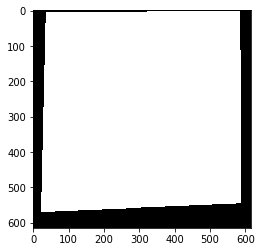

In [261]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


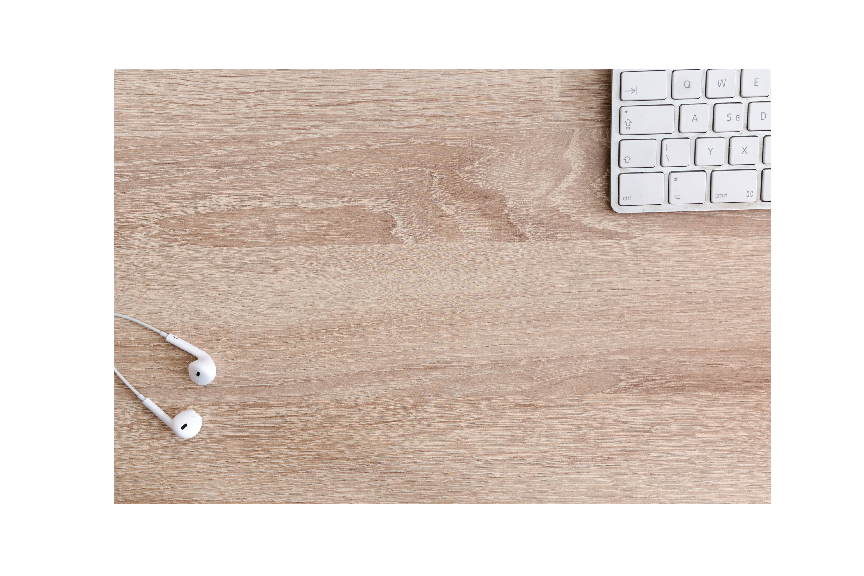

In [268]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


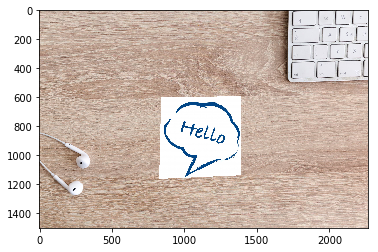

In [269]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)
print(object_mask)

## Part 2 Poisson Blending (50 pts)

In [112]:
def neighbour(x, y):
    return [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]

In [219]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    mask2 = np.zeros(background_img.shape)
    for i in range(3):
        mask2[:, :, i] = object_mask
    
    ys, xs = np.where(object_mask==1)   
    values = list(zip(ys, xs))
    val_dict = dict(zip(values, range(len(values))))    
    vs = np.zeros(background_img.shape)
    A = sp.sparse.lil_matrix((len(values)*4, len(values)))

    e = 0
    
    for index in values:
        for n in neighbour(index[0], index[1]):
            A[e, val_dict[index]] = 1
            if n in val_dict:
                A[e, val_dict[n]] = -1
            e += 1

    A = sp.sparse.csr_matrix(A)

    
    for i in range(3):
        b = np.zeros(len(values)*4)
        e = 0

        for index in values:
            for n in neighbour(index[0], index[1]):
                b[e] = cropped_object[index[0]][index[1]][i]-cropped_object[n[0]][n[1]][i]
                if n not in val_dict:
                    b[e] += background_img[n[0]][n[1]][i]
                e += 1
         
        v = sp.sparse.linalg.lsqr(A, b, atol=10**-14, btol=10**-14)[0]
        
        v[v<0] = 0
        v[v>1] = 1

        
        for key, val in val_dict.items():
            vs[key[0]][key[1]][i] = v[val]
        
    return vs + (background_img)*(1-mask2)

In [220]:
%matplotlib notebook
im_blend = poisson_blend(cropped_object, object_mask, background_img)

<IPython.core.display.Javascript object>


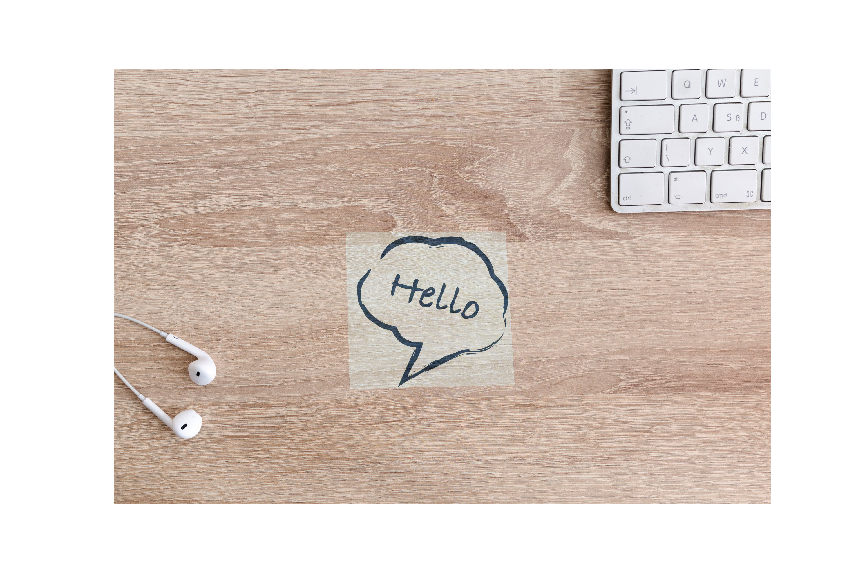

In [221]:
plt.axis('off')
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [270]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    mask2 = np.zeros(background_img.shape)
    for i in range(3):
        mask2[:, :, i] = object_mask
    
    ys, xs = np.where(object_mask==1)   
    values = list(zip(ys, xs))
    val_dict = dict(zip(values, range(len(values))))    
    vs = np.zeros(background_img.shape)
    A = sp.sparse.lil_matrix((len(values)*4, len(values)))

    e = 0
    
    for index in values:
        for n in neighbour(index[0], index[1]):
            A[e, val_dict[index]] = 1
            if n in val_dict:
                A[e, val_dict[n]] = -1
            e += 1

    A = sp.sparse.csr_matrix(A)

    
    for i in range(3):
        b = np.zeros(len(values)*4)
        e = 0

        for ind in values:
            for n in neighbour(ind[0], ind[1]):
                sg = cropped_object[ind[0]][ind[1]][i]-cropped_object[n[0]][n[1]][i]
                tg = background_img[ind[0]][ind[1]][i]-background_img[n[0]][n[1]][i]
                if abs(sg) > abs(tg):
                    b[e] = sg
                else:
                    b[e] = tg
                if n not in val_dict:
                    b[e] += background_img[n[0]][n[1]][i]
                e += 1
         
        v = sp.sparse.linalg.lsqr(A, b,atol=10**-14, btol=10**-14)[0]
        v[v<0] = 0
        v[v>1] = 1
        
        for key, val in val_dict.items():
            vs[key[0]][key[1]][i] = v[val]
        
    return vs + (background_img)*(1-mask2)

<IPython.core.display.Javascript object>


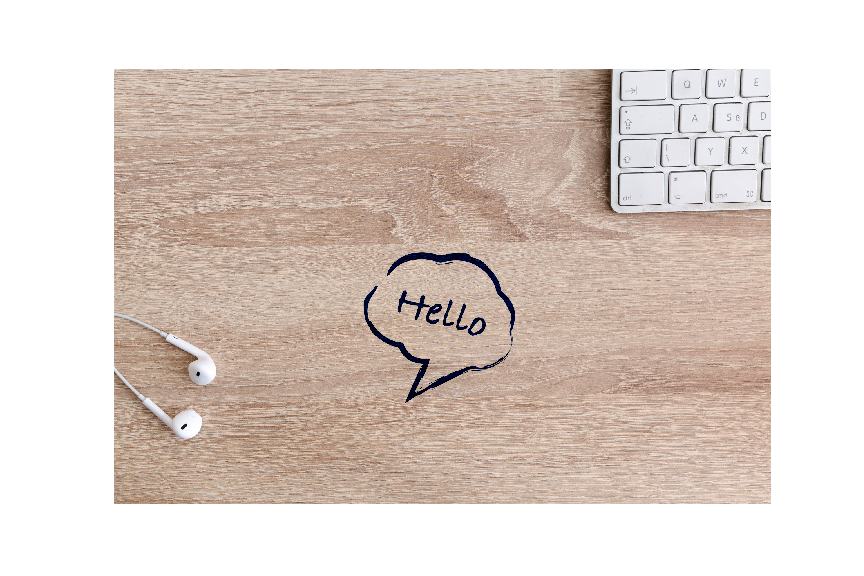

In [272]:
im_mix = mix_blend(cropped_object, object_mask, background_img)

%matplotlib notebook
plt.axis('off')
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(img1, img2):
    pass

## More gradient domain processing (up to 20 pts)